In [ ]:
!pip install scikit-multilearn

In [ ]:
!pip install neptune-client

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report, mean_squared_error, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

from skmultilearn.ensemble import MajorityVotingClassifier
from sklearn.preprocessing import LabelEncoder
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import neptune.new as neptune

plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.facecolor'] = 'white'

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

# Function definitions

In [ ]:
def import_data(filepath):
    f = h5py.File(filepath, 'r')
    V = f['voltage'][...]
    Ca = f['calcium'][...]
    t = f['time'][...]
    labels = f['labels'][...]
    return V, Ca, t, labels


def normalize_traces(traces_a, traces_b=None):
    if traces_b == None:
        traces_a_norm = []
        for trace in traces_a:
            trace_norm = (trace - trace.min()) / (trace.max() - trace.min())
            traces_a_norm.append(trace_norm)
        traces_a_norm = np.array(traces_a_norm)
        return traces_a_norm
    else:  # if pass two sets of traces, normalize traces_b relative to traces_a
        traces_a_norm, traces_b_norm = [], []
        for trace_a, trace_b in zip(traces_a, traces_b):
            traces_a_norm.append(
                (trace_a - trace_a.min()) / (trace_a.max() - trace_a.min()))
            traces_b_norm.append(
                (trace_b - trace_a.min()) / (trace_a.max() - trace_a.min()))
        traces_a_norm = np.array(traces_a_norm)
        traces_b_norm = np.array(traces_b_norm)
        return traces_a_norm, traces_b_norm


def add_noise(X, percentage=5.0):
    std = np.nanmean(X, axis=0).std()
    noise = np.random.normal(0, std, X.shape) * percentage / 100
    X_noise = X + noise
    return X_noise

# Import data

In [ ]:
#######################################################
# To get the data you should download the file from   #
# Google Drive and upload it to the working folder    #
# here in Google Colab                                #
#######################################################

data_path = "/content/data.h5"


label_order = ['Kr', 'CaL', 'Na', 'NaL', 'to', 'Ks', 'K1']

V, Ca, t, labels = import_data(data_path)
# Separate control and drug cases
V_c = V[:, :, 0]
V_d = V[:, :, 1]
Ca_c = Ca[:, :, 0]
Ca_d = Ca[:, :, 1]


# Plot data

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


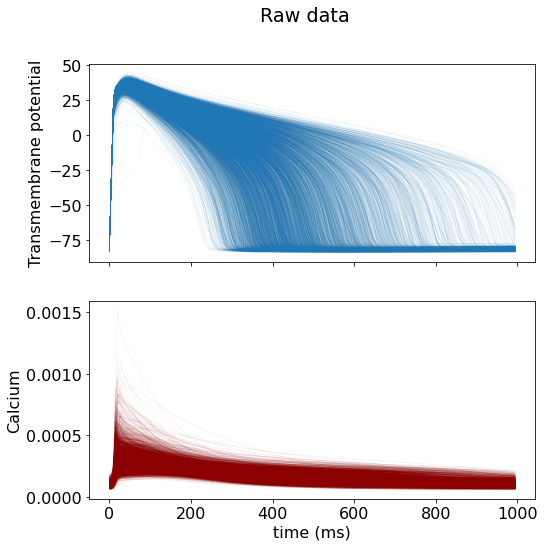

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
fig.suptitle("Raw data")
for Vp, Cap in zip(V_c, Ca_c):
    ax[0].plot(t, Vp, c='tab:blue', lw=0.4, alpha=0.1)
    ax[1].plot(t, Cap, c='darkred', lw=0.4, alpha=0.1)
    ax[0].set_ylabel("Transmembrane potential")
    ax[1].set_ylabel("Calcium")
    ax[1].set_xlabel("time (ms)")
    #ax[0].set_xlabel("time (ms)")
plt.savefig("data.png", bbox_inches='tight')

# Prep data for classifier

In [ ]:
# Add noise and combine V with Ca
def add_noise_and_normalize(V_c, V_d, Ca_c, Ca_d, pct_noise=0):
    #pct_noise = 0.0
    V_c_norm, V_d_norm = normalize_traces(add_noise(V_c,pct_noise)), normalize_traces(add_noise(V_d,pct_noise))
    Ca_c_norm, Ca_d_norm = normalize_traces(add_noise(Ca_c,pct_noise)), normalize_traces(add_noise(Ca_d,pct_noise))
    X = np.concatenate((V_d_norm-V_c_norm,Ca_d_norm-Ca_c_norm),axis=1)

    # Standardize data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

noise = 0
X = add_noise_and_normalize(V_c, V_d, Ca_c, Ca_d, noise) #, axis=1)
y = labels

# Split into training and testing
#ratio = 0.25 # test/total
#indices = np.arange(X_tmp.shape[0])
#X, y, X_super_test, y_super_test = iterative_train_test_split(X_tmp, y_tmp, test_size = ratio)
# X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_sparse, indices, test_size=ratio, random_state=None)

In [ ]:
from sklearn.preprocessing import LabelEncoder
def get_labels_for_all_combinations(y):
    y_all_combinations = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_all_combinations

# Check list - Classifiers tested:

https://app.neptune.ai/o/SSCP/org/SSCP2021/experiments?split=tbl&dash=charts&viewId=standard-view&sortBy=%5B%22Noise%22%5D&sortFieldType=%5B%22int%22%5D&sortFieldAggregationMode=%5B%22auto%22%5D&sortDirection=%5B%22ascending%22%5D&suggestionsEnabled=true&lbViewUnpacked=true

### Noise = 0 %
- [X] NB-Binary relevance
- [X] NB-Label powerset
- [X] NB-Classifier chain
- [X] SVC-Label powerset
- [X] XGBoost - Label powerset
- [X] MLP
- [X] CNN Encoder
- [X] LSTM bidir

### Noise = 1 %
- [X] NB-Binary relevance
- [X] NB-Label powerset
- [X] NB-Classifier chain
- [X] SVC-Label powerset
- [X] XGBoost - Label powerset
- [X] MLP
- [X] CNN Encoder
- [X] LSTM bidir

### Noise = 2 %
- [X] NB-Binary relevance
- [X] NB-Label powerset
- [X] NB-Classifier chain
- [X] SVC-Label powerset
- [X] XGBoost - Label powerset
- [X] MLP
- [ ] CNN Encoder
- [ ] LSTM bidir

### Noise = 3 %
- [X] NB-Binary relevance
- [X] NB-Label powerset
- [X] NB-Classifier chain
- [X] SVC-Label powerset
- [X] XGBoost - Label powerset
- [X] MLP
- [X] CNN Encoder
- [X] LSTM bidir

### Noise = 4 %
- [X] NB-Binary relevance
- [X] NB-Label powerset
- [X] NB-Classifier chain
- [X] SVC-Label powerset
- [ ] XGBoost - Label powerset
- [X] MLP
- [X] CNN Encoder
- [ ] LSTM bidir

### Noise = 5 %
- [X] NB-Binary relevance
- [X] NB-Label powerset
- [X] NB-Classifier chain
- [X] SVC-Label powerset
- [X] XGBoost - Label powerset
- [X] MLP
- [X] CNN Encoder
- [ ] LSTM bidir

# Train and test classifier


## Naive Bayes

In [ ]:
'''
clf = BinaryRelevance(classifier = GaussianNB())

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i}:",accuracy_score(y_test[:,i],y_hat[:,i]))
'''

'\nclf = BinaryRelevance(classifier = GaussianNB())\n\nstart = time.time()\nclf.fit(X_train, y_train)\nprint(\'training time: \',round(time.time()-start,2),\'seconds\')\n\ny_hat = clf.predict(X_test).toarray().astype(int)\nfor i in range(7):\n    print(f"Accuracy label {i}:",accuracy_score(y_test[:,i],y_hat[:,i]))\n'

### BinaryRelevance

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_GaussianNB_BinaryRelevance(X, y, noise):

    time_start = time.time()

    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "GaussianNB-BinaryRelevance"
    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    run["Noise"] =  noise
    
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = BinaryRelevance(classifier = GaussianNB())
        # define search space
        parameters = {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0,-9, num=10),
        }
        # define search
        search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test).toarray()
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune

        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    runtime = time.time() - time_start 
    print('Runtime: {} sec, noise: {}%'.format(runtime, noise))
    run["Runtime"] = runtime
    run.stop()


In [ ]:
run_GaussianNB_BinaryRelevance(X, y, noise)

In [ ]:
'''
# Use multi-label classifier chain (MLCC)
clf = ClassifierChain( classifier = GaussianNB() )

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))
'''

'\n# Use multi-label classifier chain (MLCC)\nclf = ClassifierChain( classifier = GaussianNB() )\n\nstart = time.time()\nclf.fit(X_train, y_train)\nprint(\'training time: \',round(time.time()-start,2),\'seconds\')\n\ny_hat = clf.predict(X_test).toarray().astype(int)\nfor i in range(7):\n    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))\n'

### ClassifierChain

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_GaussianNB_ClassifierChain(X, y, noise):

    time_start = time.time()

    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "GaussianNB-ClassifierChain"
    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = ClassifierChain(classifier = GaussianNB())
        # define search space
        parameters = {
            'classifier': [GaussianNB()],
            'classifier__var_smoothing': np.logspace(0,-9, num=10),
        }
        # define search
        search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test).toarray()
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    run["Noise"] =  noise
    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()

In [ ]:
run_GaussianNB_ClassifierChain(X, y, noise)

https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-181
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
>acc=0.013, pres=0.619, rec=0.429, f1=0.437, est=0.026, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1.0), 'classifier__var_smoothing': 1.0}
>acc=0.024, pres=0.629, rec=0.395, f1=0.437, est=0.024, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.0001), 'classifier__var_smoothing': 0.0001}
>acc=0.013, pres=0.643, rec=0.377, f1=0.423, est=0.027, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1.0), 'classifier__var_smoothing': 1.0}
>acc=0.020, pres=0.603, rec=0.540, f1=0.520, est=0.023, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.01), 'classifier__var_smoothing': 0.01}
>acc=0.011, pres=0.624, rec=0.503, f1=0.504, est=0.023, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.

Waiting for the remaining 107 operations to synchronize with Neptune. Do not kill this process.


All 107 operations synced, thanks for waiting!


In [ ]:
'''
# Formulate as label power-set
clf = LabelPowerset( classifier = GaussianNB() )

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))
    
# clf.unique_combinations_
'''

'\n# Formulate as label power-set\nclf = LabelPowerset( classifier = GaussianNB() )\n\nstart = time.time()\nclf.fit(X_train, y_train)\nprint(\'training time: \',round(time.time()-start,2),\'seconds\')\n\ny_hat = clf.predict(X_test).toarray().astype(int)\nfor i in range(7):\n    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))\n    \n# clf.unique_combinations_\n'

### LabelPowerset

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_GaussianNB_LabelPowerset(X, y, noise):

    time_start = time.time()


    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "GaussianNB-LabelPowerset"
    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = LabelPowerset(classifier = GaussianNB())
        # define search space
        parameters = {
            'classifier': [GaussianNB()],
            'classifier__var_smoothing': np.logspace(0,-9, num=10),
        }
        # define search
        search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test).toarray()
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    run["Noise"] =  noise
    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()

In [ ]:
run_GaussianNB_LabelPowerset(X, y, noise)

https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-182
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
>acc=0.142, pres=0.745, rec=0.751, f1=0.745, est=0.156, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.001), 'classifier__var_smoothing': 0.001}
>acc=0.170, pres=0.758, rec=0.760, f1=0.753, est=0.158, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1e-06), 'classifier__var_smoothing': 1e-06}
>acc=0.133, pres=0.707, rec=0.779, f1=0.739, est=0.168, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1e-07), 'classifier__var_smoothing': 1e-07}
>acc=0.146, pres=0.754, rec=0.752, f1=0.752, est=0.141, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.001), 'classifier__var_smoothing': 0.001}
>acc=0.148, pres=0.735, rec=0.753, f1=0.738, est=0.159, cfg={'classifier': GaussianNB(priors=None, var_smoo

Waiting for the remaining 109 operations to synchronize with Neptune. Do not kill this process.


All 109 operations synced, thanks for waiting!


## SVC

In [ ]:
"""
# Start with binary relevance
clf = BinaryRelevance( classifier = SVC(kernel='linear', C=1, gamma='scale', probability=True) )

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))
print("F1-score:", f1_score(y_test, yhat, average='macro'))
"""

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_SVC_LabelPowerset(X, y, noise):

    time_start = time.time()

    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "SVC-LabelPowerset"
    run["Noise"] =  noise
    
    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = LabelPowerset(classifier = SVC())
        # define search space
        parameters = {
            'classifier': [SVC()],
            'classifier__C': np.logspace(2,-2, num=3),
            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            #'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
            #https://stackoverflow.com/questions/36306555/scikit-learn-grid-search-with-svm-regression                 
        }
        # define search
        search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
        #print(X_train.shape, kernel_train.shape, y_train.shape)

        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_

        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test).toarray()

        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()


In [ ]:
run_SVC_LabelPowerset(X, y, noise)
#run_SVC_LabelPowerset(X, y, 2)

https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-231
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


KeyboardInterrupt: ignored

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_XGBoost_LabelPowerset(X, y, noise):

    time_start = time.time()


    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "XGBoost-LabelPowerset"

    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = LabelPowerset(classifier = XGBClassifier())
        # define search space
        parameters = {
            'classifier': [XGBClassifier()],
            'classifier__n_estimators': [1,5],
            'classifier__min_child_weight': [1, 5],
            'classifier__gamma': [0.5, 1],
            'classifier__subsample': [0.8],
            'classifier__colsample_bytree': [0.8],
            'classifier__max_depth': [3, 5]

        }

        # define search
        search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test).toarray()
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    run["Noise"] =  noise
    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()

In [ ]:
run_XGBoost_LabelPowerset(X, y, noise)

https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-229
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## MLP neural net with cross-validation

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_MLP_classifier(X, y, noise):

    time_start = time.time()


    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "MLP-classifier"

    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = MLPClassifier(hidden_layer_sizes=(100,))
        # define search space
        parameters = {
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001],
            'batch_size': [50, 100, 200],
            'learning_rate_init': [0.001],
            'learning_rate': ['adaptive'],
            'max_iter': [50,100,200]                 
        }

        parameter_space = {

        }
        # define search
        search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    run["Noise"] =  noise
    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()

In [ ]:
run_MLP_classifier(X, y, noise)

https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-210
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.061, pres=0.697, rec=0.687, f1=0.692, est=0.065, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.061, pres=0.680, rec=0.697, f1=0.689, est=0.063, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.070, pres=0.689, rec=0.700, f1=0.694, est=0.064, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.066, pres=0.695, rec=0.695, f1=0.695, est=0.061, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.066, pres=0.695, rec=0.698, f1=0.696, est=0.066, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.050, pres=0.682, rec=0.692, f1=0.686, est=0.065, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.074, pres=0.692, rec=0.684, f1=0.688, est=0.066, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.057, pres=0.676, rec=0.668, f1=0.672, est=0.068, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.044, pres=0.697, rec=0.704, f1=0.700, est=0.063, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/us

>acc=0.052, pres=0.684, rec=0.682, f1=0.682, est=0.062, cfg={'activation': 'relu', 'alpha': 0.0001, 'batch_size': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 50, 'solver': 'adam'}
Accuracy: 0.060 (0.008)
Runtime: 2287.517 sec
Shutting down background jobs, please wait a moment...
Done!


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
Waiting for the remaining 108 operations to synchronize with Neptune. Do not kill this process.


All 108 operations synced, thanks for waiting!


In [ ]:
'''
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def evaluate_model(X, y):
    results = list()
    results_class = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in tqdm(cv.split(X), total=30):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # make a prediction on the test set
        y_hat = model.predict(X_test)
        # round probabilities to class labels
        y_hat = y_hat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, y_hat)
        class_acc = np.zeros(7)
        for i in range(7):
          class_acc[i] = accuracy_score(y_test[:,i],y_hat[:,i])
        # store result
        results.append(acc)
        results_class.append(class_acc)
    return results, results_class

results, results_class = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))
'''

"\ndef get_model(n_inputs, n_outputs):\n    model = Sequential()\n    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))\n    model.add(Dense(n_outputs, activation='sigmoid'))\n    model.compile(loss='binary_crossentropy', optimizer='adam')\n    return model\n\ndef evaluate_model(X, y):\n    results = list()\n    results_class = list()\n    n_inputs, n_outputs = X.shape[1], y.shape[1]\n    # define evaluation procedure\n    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n    # enumerate folds\n    for train_ix, test_ix in tqdm(cv.split(X), total=30):\n        # prepare data\n        X_train, X_test = X[train_ix], X[test_ix]\n        y_train, y_test = y[train_ix], y[test_ix]\n        # define model\n        model = get_model(n_inputs, n_outputs)\n        # fit model\n        model.fit(X_train, y_train, verbose=0, epochs=100)\n        # make a prediction on the test set\n        y_hat = model.predict(X_test)\n        # round probabi

In [ ]:
'''
results_class = np.asarray(results_class)
for i in range(7):
  print(f"Accuracy label {i} - Mean: { results_class[:,i].mean() }, SD:{results_class[:,i].std()} ")
'''

'\nresults_class = np.asarray(results_class)\nfor i in range(7):\n  print(f"Accuracy label {i} - Mean: { results_class[:,i].mean() }, SD:{results_class[:,i].std()} ")\n'

## Run all the stuff

In [ ]:
#X0 = add_noise_and_normalize(V_c, V_d, Ca_c, Ca_d, pct_noise=2)
#X1 = add_noise_and_normalize(V_c, V_d, Ca_c, Ca_d, pct_noise=3.5)
#X2 = add_noise_and_normalize(V_c, V_d, Ca_c, Ca_d, pct_noise=5)

"""
This cell block runs all the methods above with diifernt levels of noise.
I'm quite sure how best to add the CNN and RNN models here.
If you create another method that fits here, feel free to add it.
"""

#noises = [2, 3, 4, 5]
noises = [3, 4, 5]
for i in range(len(noises)):
    X_curr = add_noise_and_normalize(V_c, V_d, Ca_c, Ca_d, pct_noise=noises[i])

    print("\nGaussianNB BinaryRelevance, noise={}%.".format(noises[i]))
    run_GaussianNB_BinaryRelevance(X_curr, y, noises[i])

    print("\nGaussianNB ClassifierChain, noise={}%.".format(noises[i]))
    run_GaussianNB_ClassifierChain(X_curr, y, noises[i])

    print("\nGaussianNB LabelPowerset, noise={}%.".format(noises[i]))
    run_GaussianNB_LabelPowerset(X_curr, y, noises[i])

    print("\nSVC, noise={}%.".format(noises[i]))
    run_SVC_LabelPowerset(X_curr, y, noises[i])
    
    print("\nXGBoost, noise={}%.".format(noises[i]))
    run_XGBoost_LabelPowerset(X_curr, y, noises[i])

    print("\nMLP, noise={}%.".format(noises[i]))
    run_MLP_classifier(X_curr, y, noises[i])


GaussianNB BinaryRelevance, noise=3%.
https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-203
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
>acc=0.017, pres=0.603, rec=0.394, f1=0.441, est=0.023, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1.0), 'classifier__var_smoothing': 1.0}
>acc=0.013, pres=0.588, rec=0.435, f1=0.475, est=0.015, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.01), 'classifier__var_smoothing': 0.01}
>acc=0.022, pres=0.605, rec=0.401, f1=0.456, est=0.022, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1.0), 'classifier__var_smoothing': 1.0}
>acc=0.024, pres=0.611, rec=0.543, f1=0.536, est=0.021, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.1), 'classifier__var_smoothing': 0.1}
>acc=0.017, pres=0.618, rec=0.475, f1=0.485, est=0.019, cfg={'classifier': Gaussia

Waiting for the remaining 109 operations to synchronize with Neptune. Do not kill this process.


All 109 operations synced, thanks for waiting!

GaussianNB ClassifierChain, noise=3%.
https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-204
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
>acc=0.017, pres=0.603, rec=0.394, f1=0.441, est=0.023, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1.0), 'classifier__var_smoothing': 1.0}
>acc=0.013, pres=0.588, rec=0.435, f1=0.475, est=0.015, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.01), 'classifier__var_smoothing': 0.01}
>acc=0.022, pres=0.605, rec=0.401, f1=0.456, est=0.022, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1.0), 'classifier__var_smoothing': 1.0}
>acc=0.024, pres=0.612, rec=0.543, f1=0.536, est=0.021, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.1), 'classifier__var_smoothing': 0.1}
>acc=0.017, pres=0.618, rec=0.475, 

Waiting for the remaining 107 operations to synchronize with Neptune. Do not kill this process.


All 107 operations synced, thanks for waiting!

GaussianNB LabelPowerset, noise=3%.
https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-205
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
>acc=0.037, pres=0.645, rec=0.570, f1=0.603, est=0.046, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.01), 'classifier__var_smoothing': 0.01}
>acc=0.068, pres=0.639, rec=0.597, f1=0.616, est=0.050, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.01), 'classifier__var_smoothing': 0.01}
>acc=0.044, pres=0.630, rec=0.622, f1=0.625, est=0.052, cfg={'classifier': GaussianNB(priors=None, var_smoothing=1e-05), 'classifier__var_smoothing': 1e-05}
>acc=0.046, pres=0.646, rec=0.585, f1=0.613, est=0.045, cfg={'classifier': GaussianNB(priors=None, var_smoothing=0.0001), 'classifier__var_smoothing': 0.0001}
>acc=0.055, pres=0.640, r

Waiting for the remaining 107 operations to synchronize with Neptune. Do not kill this process.


All 107 operations synced, thanks for waiting!

XGBoost, noise=3%.
https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-206
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


KeyboardInterrupt: ignored

## CNN

In [ ]:
def encoder_model(n_input, n_output):
    X_input=tf.keras.layers.Input(shape=(n_input))
     # conv block -1
    conv1 = tf.keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(X_input)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = tf.keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = tf.keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = tf.keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = tf.keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = tf.keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = tf.keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = tf.keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = tf.keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = tf.keras.layers.Lambda(lambda x: x[:,:,:])(conv3)
    attention_softmax = tf.keras.layers.Lambda(lambda x: x[:,:,:])(conv3)
    # attention mechanism
    attention_softmax = tf.keras.layers.Softmax()(attention_softmax)
    multiply_layer = tf.keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = tf.keras.layers.Dense(units=512,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = tf.keras.layers.Flatten()(dense_layer)
    output_layer = tf.keras.layers.Dense(units=n_output,activation='sigmoid')(flatten_layer)

    model = tf.keras.Model(inputs=X_input, outputs=output_layer)


    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")
                  #,tfa.metrics.F1Score(num_classes=n_output)
                  ])
    return model

In [ ]:
def encoder_model_2():
    X_input=tf.keras.layers.Input(shape=(200,2))
     # conv block -1
    conv1 = tf.keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(X_input)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = tf.keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = tf.keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = tf.keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = tf.keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = tf.keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = tf.keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = tf.keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = tf.keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = tf.keras.layers.Lambda(lambda x: x[:,:,:])(conv3)
    attention_softmax = tf.keras.layers.Lambda(lambda x: x[:,:,:])(conv3)
    # attention mechanism
    attention_softmax = tf.keras.layers.Softmax()(attention_softmax)
    multiply_layer = tf.keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = tf.keras.layers.Dense(units=512,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = tf.keras.layers.Flatten()(dense_layer)
    output_layer = tf.keras.layers.Dense(units=7,activation='sigmoid')(flatten_layer)

    model = tf.keras.Model(inputs=X_input, outputs=output_layer)


    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])
    return model

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
# Add noise and combine V with Ca
def add_noise_and_normalize_new_axis(V_c, V_d, Ca_c, Ca_d, pct_noise=0):
    #pct_noise = 0.0
    V_c_norm, V_d_norm = normalize_traces(add_noise(V_c,pct_noise)), normalize_traces(add_noise(V_d,pct_noise))
    Ca_c_norm, Ca_d_norm = normalize_traces(add_noise(Ca_c,pct_noise)), normalize_traces(add_noise(Ca_d,pct_noise))
    V_diff = V_d_norm-V_c_norm
    Ca_diff = Ca_d_norm-Ca_c_norm
    scaler_V = StandardScaler()
    scaler_Ca = StandardScaler()
    X_v = scaler_V.fit_transform(V_diff)
    X_Ca = scaler_Ca.fit_transform(Ca_diff)


    X = np.concatenate((np.expand_dims(X_v,axis = 2),np.expand_dims(X_Ca,axis = 2)) ,axis=2)

    return X

In [ ]:
X_new = add_noise_and_normalize_new_axis(V_c, V_d, Ca_c, Ca_d, noise)

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_CNN(X_new, y, noise):

    time_start = time.time()

    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "CNN-model - Encoder"
    run["Data"] = "Ca and V on separate axis"
    run["Noise"] =  noise

    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X_new,y_transformed)):
        # split data
        X_train, X_test = X_new[train_ix, :, :], X_new[test_ix, :,:]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = KerasClassifier(build_fn=encoder_model_2, verbose=1)
        # define search space
        parameters = {
            'epochs': [20,60,100],
            'batch_size': [20,60,100]
        }
        # define search
        search = GridSearchCV(model, parameters, cv=cv_inner, refit=True)
        #search = GridSearchCV(estimator=model, param_grid=parameters)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset

        yhat = (best_model.predict_proba(X_test) > 0.5) * 1
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()

In [ ]:
run_CNN(X_new, y, noise)

Streaming output truncated to the last 5000 lines.
Epoch 44/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0184 - accuracy: 0.9934
Epoch 45/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0185 - accuracy: 0.9943
Epoch 46/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0196 - accuracy: 0.9935
Epoch 47/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0207 - accuracy: 0.9923
Epoch 48/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0203 - accuracy: 0.9933
Epoch 49/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0209 - accuracy: 0.9932
Epoch 50/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0192 - accuracy: 0.9932
Epoch 51/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0172 - accuracy: 0.9943
Epoch 52/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0190 - accuracy: 0.9933
Epoch 53/100
46/46 [====================

Waiting for the remaining 248 operations to synchronize with Neptune. Do not kill this process.


All 248 operations synced, thanks for waiting!


## LSTM

In [ ]:
def LSTM_net():
    inputlayer = tf.keras.layers.Input(shape=(200,2)) 

    lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True))(inputlayer)
    lstm2 = tf.keras.layers.LSTM(50)(lstm1)
    output_layer = tf.keras.layers.Dense(units=7,activation='sigmoid')(lstm2)

    model = tf.keras.Model(inputs=inputlayer, outputs=output_layer)

    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")
                  #,tfa.metrics.F1Score(num_classes=n_output)
                  ])
    return model

In [ ]:
##-----------------------------------------------------------------------------------------------#
#|  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ |
##-----------------------------------------------------------------------------------------------#

def run_LSTM(X_new, y, noise):

    time_start = time.time()

    #Neptune credentials
    run = neptune.init(project='SSCP/SSCP2021',
                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMGUyN2Q2ZS05MjVkLTRlMzItODYwZS0yODQ3ZWU3ZTdmMmEifQ==')
    run["Model"] = "LSTM-Bidir"
    run["Data"] = "Ca and V on separate axis"
    run["Noise"] =  noise
    #Define outer loop - 10-fold CV
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    y_transformed = get_labels_for_all_combinations(y)
    run["CV_folds_outer_loop"] = cv_outer.get_n_splits()
    # enumerate splits
    outer_results = list()
    class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
    for k , (train_ix, test_ix) in enumerate(cv_outer.split(X_new,y_transformed)):
        # split data
        X_train, X_test = X_new[train_ix, :, :], X_new[test_ix, :,:]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        #run["CV_folds_inner_loop"] = cv_inner.get_n_splits()
        # define the model
        model = KerasClassifier(build_fn=LSTM_net, verbose=0)
        #model.fit(X_train, y_train, verbose=1, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test,y_test))
        # define search space
        parameters = {
            'epochs': [20,60,100],
            'batch_size': [20,60,100]
        }
        # define search
        search = GridSearchCV(model, parameters, cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = (best_model.predict_proba(X_test) > 0.5) * 1
        # evaluate the model
        acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
        pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
        # store the result
        outer_results.append([acc, pres, rec, f1])
        # report progress
        print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
        #log params to Neptune
        run["hyperparameters"].log(result.best_params_)
        run["accuracy_inner_loop"].log(result.best_score_)
        run["accuracy_outer_loop"].log(acc)
        run["precision_outer_loop"].log(pres)
        run["recall_outer_loop"].log(rec)
        run["fscore_outer_loop"].log(f1)
        #finds and logs the evaluation for each outnode
        for channel in range(len(label_order)):
            curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
            curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')
            run["accuracy_outer_loop_"+label_order[channel]].log(curr_acc)
            run["precision_outer_loop_"+label_order[channel]].log(curr_pres)
            run["recall_outer_loop_"+label_order[channel]].log(curr_rec)
            run["fscore_outer_loop_"+label_order[channel]].log(curr_f1)
            class_results[k,channel,0] = curr_acc
            class_results[k,channel,1] = curr_pres
            class_results[k,channel,2] = curr_rec
            class_results[k,channel,3] = curr_f1

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean([i[0] for i in outer_results]), np.std([i[3] for i in outer_results])))
    run["accuracy_mean"] = np.mean([i[0] for i in outer_results])
    run["accuracy_SD"] =  np.std([i[0] for i in outer_results])
    run["precision_mean"] = np.mean([i[1] for i in outer_results])
    run["precision_SD"] =  np.std([i[1] for i in outer_results])
    run["recall_mean"] = np.mean([i[2] for i in outer_results])
    run["recall_SD"] =  np.std([i[2] for i in outer_results])
    run["F1_mean"] = np.mean([i[2] for i in outer_results])
    run["F1_SD"] =  np.std([i[2] for i in outer_results])
    for num_score, score in enumerate(["accuracy","presicion","recall", "F1-score"]):
        for channel in range(len(label_order)):
            run[score + "_" + label_order[channel] + "_mean"] =  class_results[:,channel,num_score].mean()
            run[score + "_" + label_order[channel] + "_SD"] =  class_results[:,channel,num_score].std()

    
    runtime = time.time() - time_start 
    print('Runtime: %.3f sec' % runtime)
    run["Runtime"] = runtime
    run.stop()

In [ ]:
run_LSTM(X_new, y, noise)

https://app.neptune.ai/SSCP/SSCP2021/e/SSCP-228
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
>acc=0.159, pres=0.785, rec=0.786, f1=0.785, est=0.795, cfg={'batch_size': 60, 'epochs': 100}
>acc=0.135, pres=0.766, rec=0.788, f1=0.777, est=0.797, cfg={'batch_size': 60, 'epochs': 100}
>acc=0.190, pres=0.795, rec=0.816, f1=0.805, est=0.797, cfg={'batch_size': 60, 'epochs': 100}
>acc=0.240, pres=0.835, rec=0.812, f1=0.822, est=0.783, cfg={'batch_size': 60, 'epochs': 100}
>acc=0.186, pres=0.819, rec=0.798, f1=0.807, est=0.782, cfg={'batch_size': 100, 'epochs': 100}
>acc=0.087, pres=0.740, rec=0.703, f1=0.716, est=0.783, cfg={'batch_size': 60, 'epochs': 100}
>acc=0.194, pres=0.808, rec=0.775, f1=0.790, est=0.790, cfg={'batch_size': 60, 'epochs': 100}
>acc=0.120, pres=0.749, rec=0.789, f1=0.763, est=0.797, cfg={'batch_size': 6

Waiting for the remaining 106 operations to synchronize with Neptune. Do not kill this process.


All 106 operations synced, thanks for waiting!


## Run CNN and LSTM

In [ ]:
#noises = [2, 3, 4, 5]
noises = [2,4,5]
for i in range(len(noises)):
    X_curr = add_noise_and_normalize_new_axis(V_c, V_d, Ca_c, Ca_d, pct_noise=noises[i])

    #print("\nCNN, noise={}%:".format(noises[i]))
    #run_CNN(X_curr, y, noises[i])

    print("\nLSTM, noise={}%:".format(noises[i]))
    run_LSTM(X_curr, y, noises[i])


# Experiments:

In [ ]:
!pip install -U keras

In [ ]:
!pip install arff

In [ ]:
def create_model_multiclass(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
KERAS_PARAMS = dict(epochs=20, batch_size=30, verbose=1)

In [ ]:
import pickle

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.ext import Keras

clf = BinaryRelevance(classifier=Keras(create_model_multiclass, True, KERAS_PARAMS), require_dense=[True,True])
clf.fit(X,y)
y_pred = clf.predict(X_super_test)
acc = f1_score(y_super_test, y_pred, average='macro')
print(f"F1-score: {acc}")

In [ ]:
def encoder_model_soft(input_dim, output_dim):
    X_input=tf.keras.layers.Input(shape=(input_dim))
     # conv block -1
    reshape = tf.keras.layers.Reshape((200,2))(X_input)
    conv1 = tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='same')(reshape)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = tf.keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = tf.keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = tf.keras.layers.Conv1D(filters=64,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = tf.keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = tf.keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = tf.keras.layers.Conv1D(filters=128,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = tf.keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = tf.keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = tf.keras.layers.Lambda(lambda x: x[:,:,:])(conv3)
    attention_softmax = tf.keras.layers.Lambda(lambda x: x[:,:,:])(conv3)
    # attention mechanism
    attention_softmax = tf.keras.layers.Softmax()(attention_softmax)
    multiply_layer = tf.keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = tf.keras.layers.Dense(units=128,activation='relu')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = tf.keras.layers.Flatten()(dense_layer)
    output_layer = tf.keras.layers.Dense(units=output_dim,activation='softmax')(flatten_layer)

    model = tf.keras.Model(inputs=X_input, outputs=output_layer)


    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from skmultilearn.dataset import load_dataset

X_train, y_train, feature_names, label_names = load_dataset('emotions', 'train')
X_test, y_test, _, _ = load_dataset('emotions', 'test')

emotions:train - exists, not redownloading
emotions:test - exists, not redownloading


In [ ]:
y_train

<391x6 sparse matrix of type '<class 'numpy.int64'>'
	with 709 stored elements in List of Lists format>

In [ ]:

def create_model_multiclass(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from skmultilearn.problem_transform import LabelPowerset
clf = LabelPowerset(classifier=Keras(create_model_multiclass, True, KERAS_PARAMS), require_dense=[True,True])
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
from scipy import sparse
sX = sparse.csr_matrix(X,dtype=np.int64)
sy = sparse.csr_matrix(y,dtype=np.int64)

In [ ]:
sy

<2908x7 sparse matrix of type '<class 'numpy.longlong'>'
	with 10940 stored elements in Compressed Sparse Row format>

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.ext import Keras
#y = labels
#X, y, X_super_test, y_super_test = iterative_train_test_split(X_new, y, test_size = ratio)
clf = LabelPowerset(classifier=Keras(encoder_model_soft, True, KERAS_PARAMS), require_dense=[True,True])
clf.fit(sX,sy)
#y_pred = clf.predict(X_super_test)
#acc = f1_score(y_super_test, y_pred, average='macro')
#print(f"F1-score: {acc}")

Epoch 1/20
97/97 [==============================] - 12s 108ms/step - loss: 4.6640 - accuracy: 0.0506
Epoch 2/20
97/97 [==============================] - 10s 107ms/step - loss: 3.6461 - accuracy: 0.0970
Epoch 3/20
97/97 [==============================] - 10s 107ms/step - loss: 3.2334 - accuracy: 0.1475
Epoch 4/20
97/97 [==============================] - 10s 107ms/step - loss: 2.8684 - accuracy: 0.2084
Epoch 5/20
97/97 [==============================] - 10s 107ms/step - loss: 2.5994 - accuracy: 0.2679
Epoch 6/20
97/97 [==============================] - 10s 107ms/step - loss: 2.3246 - accuracy: 0.3215
Epoch 7/20
97/97 [==============================] - 10s 107ms/step - loss: 2.1092 - accuracy: 0.3879
Epoch 8/20
97/97 [==============================] - 10s 107ms/step - loss: 1.8732 - accuracy: 0.4752
Epoch 9/20
97/97 [==============================] - 10s 106ms/step - loss: 1.7030 - accuracy: 0.5199
Epoch 10/20
97/97 [==============================] - 10s 106ms/step - loss: 1.5644 - accura

LabelPowerset(classifier=Keras(build_function=<function encoder_model_soft at 0x7f92b50e0c20>,
                               keras_params={'batch_size': 30, 'epochs': 20,
                                             'verbose': 1},
                               multi_class=True),
              require_dense=[True, True])

In [ ]:
y_pred = clf.predict(X_super_test)

AttributeError: ignored

In [ ]:

acc = f1_score(y_super_test, y_pred, average='macro')
print(f"F1-score: {acc}")

In [ ]:
X.shape

(2921, 400)

In [ ]:
y.shape

(2921, 7)

# Explain with Lime

In [ ]:
  time_start = time.time()

  #Neptune credentials

  
  #Define outer loop - 10-fold CV
  cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
  y_transformed = get_labels_for_all_combinations(y)
 
  # enumerate splits
  outer_results = list()
  class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
  for k , (train_ix, test_ix) in enumerate(cv_outer.split(X,y_transformed)):
      # split data
      X_train, X_test = X[train_ix, :], X[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]
      # configure the cross-validation procedure
      cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
      # define the model
      model = LabelPowerset(classifier = SVC())
      # define search space
      parameters = {
          'classifier': [SVC(probability=True)],
          #'classifier__C': np.logspace(2,-2, num=3),
          #'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          #'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          #https://stackoverflow.com/questions/36306555/scikit-learn-grid-search-with-svm-regression                 
      }
      # define search
      search = GridSearchCV(model, parameters, scoring='accuracy', cv=cv_inner, refit=True)
      #print(X_train.shape, kernel_train.shape, y_train.shape)

      # execute search
      result = search.fit(X_train, y_train)
      # get the best performing model fit on the whole training set
      best_model = result.best_estimator_

      # evaluate model on the hold out dataset
      yhat = best_model.predict(X_test).toarray()

      # evaluate the model
      acc = accuracy_score(y_test, (yhat>0.5)*1) #f1_score(y_test, yhat, average='macro')
      pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
      # store the result
      outer_results.append([acc, pres, rec, f1])
      # report progress
      print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
      #log params to Neptune

      #finds and logs the evaluation for each outnode
      for channel in range(len(label_order)):
          curr_acc = accuracy_score(y_test[:,channel], yhat[:,channel]) #f1_score(y_test, yhat, average='macro')
          curr_pres, curr_rec, curr_f1, curr_sup = precision_recall_fscore_support(y_test[channel], yhat[channel], average='macro')

          class_results[k,channel,0] = curr_acc
          class_results[k,channel,1] = curr_pres
          class_results[k,channel,2] = curr_rec
          class_results[k,channel,3] = curr_f1
      #break model after one fold
      break


>acc=0.126, pres=0.755, rec=0.709, f1=0.731, est=0.060, cfg={'classifier': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)}


In [ ]:
!pip install lime

In [ ]:
import lime
from lime import lime_tabular
import tensorflow as tf

In [ ]:
X_test.shape

(459, 400)

In [ ]:
X_test[:100].shape

(100, 400)

In [ ]:
X_test[100:101].shape

(1, 400)

In [ ]:
np.expand_dims(X_test[101],axis=1).shape

(400, 1)

In [ ]:
tf.keras.utils.to_categorical(y_test[:100,0])

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(np.expand_dims(X_test[:100],axis=2),training_labels=tf.keras.utils.to_categorical(y_test[:100,0]), feature_names=["Ca2+ and V Signal"],
                                                   discretize_continuous=False, feature_selection='auto', class_names=['no block','block'])

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test[:100],training_labels=tf.keras.utils.to_categorical(y_test[:100,0]), feature_names=["Ca2+ and V Signal"], class_names=['no block','block'], discretize_continuous=False)

In [ ]:
exp = explainer.explain_instance(X_test[100:101], wrapped_mod.predict_proba, num_features=2)

TypeError: ignored

In [ ]:
best_model.predict_proba(X_test[100:101]).toarray().ravel()[0]

0.25773902348280603

In [ ]:
class model_wrapper:
    # drf is the h2o distributed random forest object, the column_names is the
    # labels of the X values
    def __init__(self,model):
            
            self.model = model
 
    def predict_proba(self,input_data):        
        # If we have just 1 row of data we need to reshape it

        #input_data = input_data[:,:,0]


        # Predict with the h2o drf
        self.pred = self.model.predict_proba(input_data).toarray().ravel()[0]

        
        

        return np.array([[1-self.pred,self.pred]])

In [ ]:
wrapped_mod = model_wrapper(best_model)

In [ ]:
exp = explainer.explain_instance(np.expand_dims(X_test[100:101],axis=2),wrapped_mod.predict_proba, num_features=400)

ValueError: ignored

In [ ]:
exp.as_list()

In [ ]:
best_model.predict(X_test[100:101]).toarray()

array([[0, 0, 0, 0, 0, 0, 1]])

In [ ]:
1-best_model.predict_proba(X_test[100:101]).toarray()

array([[0.74226098, 0.77087529, 0.6116004 , 0.71608946, 0.63286082,
        0.29217223, 0.40948496]])

In [ ]:
wrapped_mod.predict_proba(np.expand_dims(X_test[100:101],axis=2))

array([0.74226098, 0.25773902])

In [ ]:
time_start = time.time()

#Define outer loop - 10-fold CV
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
y_transformed = get_labels_for_all_combinations(y)

# enumerate splits
outer_results = list()
class_results = np.zeros((cv_outer.get_n_splits(),len(label_order),4))
for k , (train_ix, test_ix) in enumerate(cv_outer.split(X_new,y_transformed)):
    # split data
    X_train, X_test = X_new[train_ix, :, :], X_new[test_ix, :,:]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

    # define the model
    model = KerasClassifier(build_fn=encoder_model_2, verbose=1)
    # define search space
    parameters = {
        #'epochs': [20,60,100],
        'epochs': [20],
        #'batch_size': [20,60,100]
        'batch_size': [20] 
    }
    # define search
    search = GridSearchCV(model, parameters, cv=cv_inner, refit=True)
    #search = GridSearchCV(estimator=model, param_grid=parameters)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset

    yhat = (best_model.predict_proba(X_test) > 0.5) * 1
    # evaluate the model
    acc = accuracy_score(y_test, yhat) #f1_score(y_test, yhat, average='macro')
    pres, rec, f1, sup = precision_recall_fscore_support(y_test, yhat, average='macro')
    # store the result
    outer_results.append([acc, pres, rec, f1])
    # report progress
    print('>acc=%.3f, pres=%.3f, rec=%.3f, f1=%.3f, est=%.3f, cfg=%s' % (acc, pres, rec, f1, result.best_score_, result.best_params_))
    break


